# EDA Notebook for EGX30 Market Data

This notebook performs exploratory data analysis on the EGX30 market dataset, including data loading, cleaning, quality checks, statistical analysis, and visualizations.


In [1]:
# Standard library imports
import os
from pathlib import Path
import sys  

ROOT_DIR = Path().resolve().parents[1]
sys.path.append(str(ROOT_DIR))

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import patches
from scipy.stats import norm

# Local application imports
from config.paths import RAW_MARKET_FILE, EDA_OUTPUT_DIR


In [2]:
# Data Loading
df = pd.read_csv(RAW_MARKET_FILE)


In [3]:
# Initial Data Inspection
print("Data shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nFirst 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())
print("\nSummary statistics:")
print(df.describe())
print("\nInfo:")
df.info()


Data shape: (119031, 8)

Columns: ['date', 'symbol', 'open', 'high', 'low', 'close', 'volume', 'Ticker']

Data types:
date       object
symbol     object
open      float64
high      float64
low       float64
close     float64
volume    float64
Ticker     object
dtype: object

First 5 rows:
                  date    symbol      open      high       low     close  \
0  2001-05-15 10:00:00  EGX:CIEB  0.081230  0.081258  0.081230  0.081258   
1  2001-05-16 10:00:00  EGX:CIEB  0.081230  0.084031  0.081230  0.082183   
2  2001-05-16 10:00:00  EGX:ORHD  0.398725  0.398725  0.380764  0.396569   
3  2001-05-17 10:00:00  EGX:CIEB  0.084031  0.086272  0.084031  0.086132   
4  2001-05-20 10:00:00  EGX:CIEB  0.090334  0.090446  0.089633  0.090390   

         volume Ticker  
0  6.001330e+05   CIEB  
1  7.354396e+05   CIEB  
2  1.058569e+05   ORHD  
3  1.082453e+06   CIEB  
4  2.371614e+06   CIEB  

Last 5 rows:
                       date    symbol   open   high    low  close     volume  \
119026  

In [4]:
# Data Cleaning and Preprocessing
# Standardize column names
df.columns = df.columns.str.lower()
df.rename(columns={"price": "close"}, inplace=True)

# Convert date to datetime
df["date"] = pd.to_datetime(df["date"])

# Ensure numeric types
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
df['open'] = pd.to_numeric(df['open'], errors='coerce')
df['high'] = pd.to_numeric(df['high'], errors='coerce')
df['low'] = pd.to_numeric(df['low'], errors='coerce')

# Calculate log returns (consolidated method)
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
df['abs_returns'] = df['log_returns'].abs()


In [5]:
# Data Quality Checks
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check for duplicates
duplicates = df.duplicated(subset=['date', 'symbol']).sum()
print(f"\nDuplicate rows based on Date and Symbol: {duplicates}")

# Check for zero/negative prices
zero_prices = (df[['open', 'high', 'low', 'close']] <= 0).sum()
print("\nZero or negative price counts:")
print(zero_prices)

# Check for negative volume
negative_volume = (df['volume'] < 0).sum()
print(f"\nNegative volume count: {negative_volume}")

# Check if close is within high-low range
violations = df[(df['close'] > df['high']) | (df['close'] < df['low'])]
if not violations.empty:
    print(f"\nWarning: Found {len(violations)} rows where Close is outside High-Low range.")
else:
    print("\nLogic Check Passed: Close price stays within High-Low range.")

# Check dataset balance
balance_check = df['symbol'].value_counts()
is_balanced = balance_check.nunique() == 1
print(f"\nIs the dataset perfectly balanced? {is_balanced}")
print("Counts per company:")
print(balance_check)

# Check for outliers in close price
Q1 = df['close'].quantile(0.25)
Q3 = df['close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['close'] < lower_bound) | (df['close'] > upper_bound)]
print(f"\nNumber of extreme outliers in close price: {len(outliers)}")

# Check for missing dates
full_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
missing_dates = full_range.difference(df['date'].dt.normalize().unique())
print(f"\nNumber of missing trading dates: {len(missing_dates)}")

# Universe coverage
coverage = df.groupby(df['date'].dt.year)['symbol'].nunique()
print("\nUniverse coverage by year:")
print(coverage)


Missing values per column:
date           0
symbol         0
open           0
high           0
low            0
close          0
volume         0
ticker         0
log_returns    1
abs_returns    1
dtype: int64

Duplicate rows based on Date and Symbol: 0

Zero or negative price counts:
open     0
high     0
low      0
close    0
dtype: int64

Negative volume count: 0


Is the dataset perfectly balanced? False
Counts per company:
symbol
EGX:EAST     5000
EGX:EGAL     5000
EGX:ADIB     5000
EGX:SUGR     5000
EGX:ABUK     5000
EGX:HELI     5000
EGX:EXPA     5000
EGX:ORWE     5000
EGX:MASR     5000
EGX:EFIC     5000
EGX:HRHO     5000
EGX:AMOC     4929
EGX:ORHD     4906
EGX:CIEB     4879
EGX:ETEL     4879
EGX:SWDY     4753
EGX:TMGH     4400
EGX:PHDC     4294
EGX:CCAP     3905
EGX:JUFO     3767
EGX:CIRA     3632
EGX:BTFH     3457
EGX:COMI     2473
EGX:DOMT     2418
EGX:MFPC     2290
EGX:ESRS     2247
EGX:MTIE     2150
EGX:ISPH     1989
EGX:FWRY     1589
EGX:EKHOA    1074
Name: count, dtype: i

In [6]:
# Statistical Analysis
# Stationarity test
print("ADF Test for Stationarity (Close Price):")
result = adfuller(df['close'].dropna())
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')
if result[1] <= 0.05:
    print("Result: Stationary")
else:
    print("Result: Non-Stationary")

# Normality tests
skewness = df['log_returns'].skew()
kurtosis = df['log_returns'].kurtosis()
print(f"\nSkewness of log returns: {skewness:.4f}")
print(f"Excess Kurtosis of log returns: {kurtosis:.4f}")

jb_stat, jb_p = stats.jarque_bera(df['log_returns'].dropna())
print(f"Jarque-Bera p-value: {jb_p:.4f}")
if jb_p < 0.05:
    print("Decision: Returns are NOT normally distributed.")
else:
    print("Decision: Returns appear to be normally distributed.")

# Correlations
volume_volatility_corr = df['volume'].corr(df['abs_returns'])
print(f"\nCorrelation between Volume and Absolute Returns: {volume_volatility_corr:.4f}")

# Autocorrelation
lag_corr = df[['log_returns']].corrwith(df['log_returns'].shift(1), axis=0)
print(f"\nAutocorrelation at lag 1: {lag_corr.iloc[0]:.4f}")

# Rolling statistics for stationarity check
window = 252
rolling_mean = df['close'].rolling(window=window).mean()
rolling_std = df['close'].rolling(window=window).std()
print(f"\nRolling mean (252 days) std: {rolling_mean.std():.4f}")
print(f"Rolling std (252 days) mean: {rolling_std.mean():.4f}")


ADF Test for Stationarity (Close Price):
ADF Statistic: 2.2699
p-value: 0.9989
Result: Non-Stationary

Skewness of log returns: 0.1026
Excess Kurtosis of log returns: -0.4795
Jarque-Bera p-value: 0.0000
Decision: Returns are NOT normally distributed.

Correlation between Volume and Absolute Returns: 0.0128

Autocorrelation at lag 1: -0.5193

Rolling mean (252 days) std: 9.4714
Rolling std (252 days) mean: 10.6709


In [7]:
# Potential stock splits detection
df['pct_change'] = df.groupby('symbol')['close'].pct_change()
potential_splits = df[df['pct_change'] < -0.20].copy()
if not potential_splits.empty:
    potential_splits['est_ratio'] = 1 / (1 + potential_splits['pct_change'])
    def round_to_split(x):
        ratios = [1.25, 1.5, 2, 3, 4, 5, 10]
        return min(ratios, key=lambda r: abs(r - x))
    potential_splits['clean_ratio'] = potential_splits['est_ratio'].apply(round_to_split)
    print("Potential stock splits detected:")
    print(potential_splits[['symbol', 'date', 'close', 'pct_change', 'clean_ratio']].head())
else:
    print("No potential stock splits detected.")


Potential stock splits detected:
        symbol                date      close  pct_change  clean_ratio
358   EGX:DOMT 2003-10-02 10:00:00  25.000000   -0.750000         4.00
1120  EGX:ORHD 2005-03-17 10:00:00   3.722493   -0.200470         1.25
3932  EGX:HRHO 2006-03-14 10:00:00   9.206890   -0.235673         1.25
3933  EGX:MASR 2006-03-14 10:00:00   0.521976   -0.200299         1.25
5099  EGX:HRHO 2006-07-16 10:00:00   6.409402   -0.205449         1.25


In [8]:
# Save errors report if any
wrong_close = df[df['close'] <= 0]
wrong_volume = df[df['volume'] < 0]
missing_data = df[df.isnull().any(axis=1)]
errors_list = []

if not wrong_close.empty:
    wrong_close = wrong_close.copy()
    wrong_close['Error_Type'] = 'Zero or Negative Close'
    errors_list.append(wrong_close)

if not wrong_volume.empty:
    wrong_volume = wrong_volume.copy()
    wrong_volume['Error_Type'] = 'Negative Volume'
    errors_list.append(wrong_volume)
 
if not missing_data.empty:
    missing_data = missing_data.copy()
    missing_data['Error_Type'] = 'Missing Values (NaN)'
    errors_list.append(missing_data)

if errors_list:
    all_errors_df = pd.concat(errors_list).drop_duplicates()
    print(f"Found {len(all_errors_df)} errors in the dataset.")
    all_errors_df.to_csv(EDA_OUTPUT_DIR / 'data_errors_report.csv', index=False)
else:
    print("No errors found in the dataset.")


Found 30 errors in the dataset.


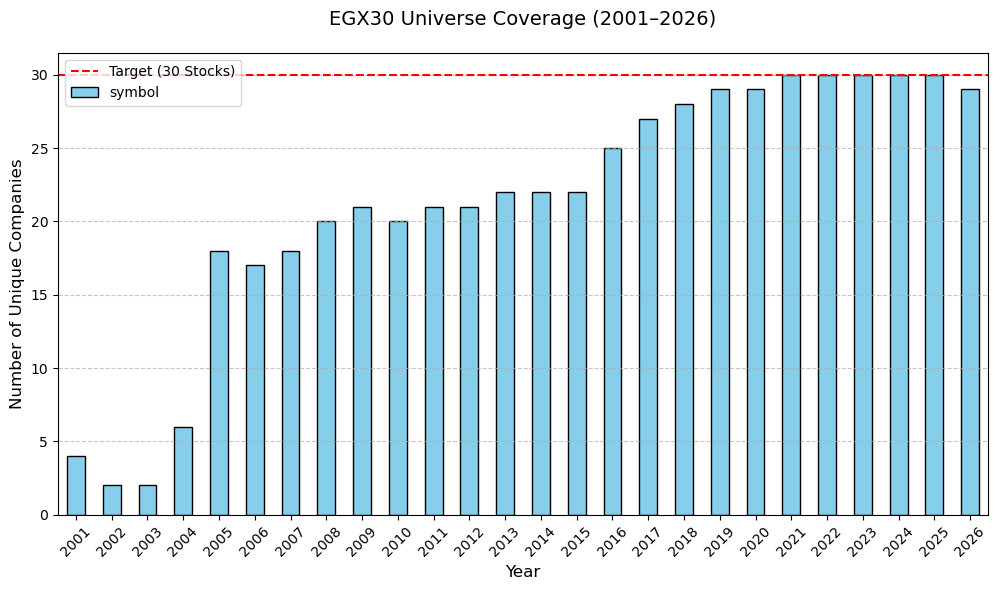

In [9]:
# Plot 1: EGX30 Universe Coverage by Year
# This bar chart shows the number of unique companies in the EGX30 index each year from 2001 to 2026, with a target line at 30 stocks.
plt.figure(figsize=(12, 6))
coverage.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('EGX30 Universe Coverage (2001–2026)', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Unique Companies', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=30, color='red', linestyle='--', label='Target (30 Stocks)')
plt.legend()
plt.show()


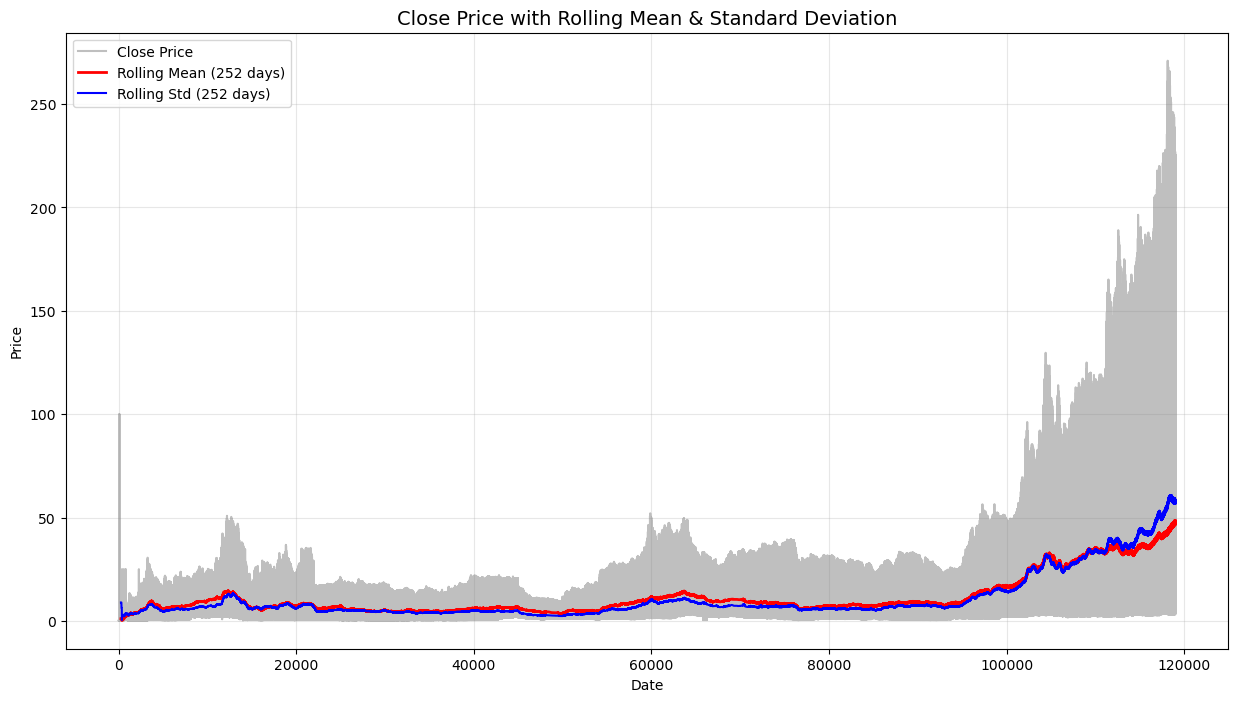

In [10]:
# Plot 2: Close Price Time Series with Rolling Statistics
# This plot displays the close price over time, along with 252-day rolling mean and standard deviation to check for stationarity and trends.
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['close'], color='gray', alpha=0.5, label='Close Price')
plt.plot(rolling_mean.index, rolling_mean, color='red', lw=2, label='Rolling Mean (252 days)')
plt.plot(rolling_std.index, rolling_std, color='blue', lw=1.5, label='Rolling Std (252 days)')
plt.title('Close Price with Rolling Mean & Standard Deviation', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


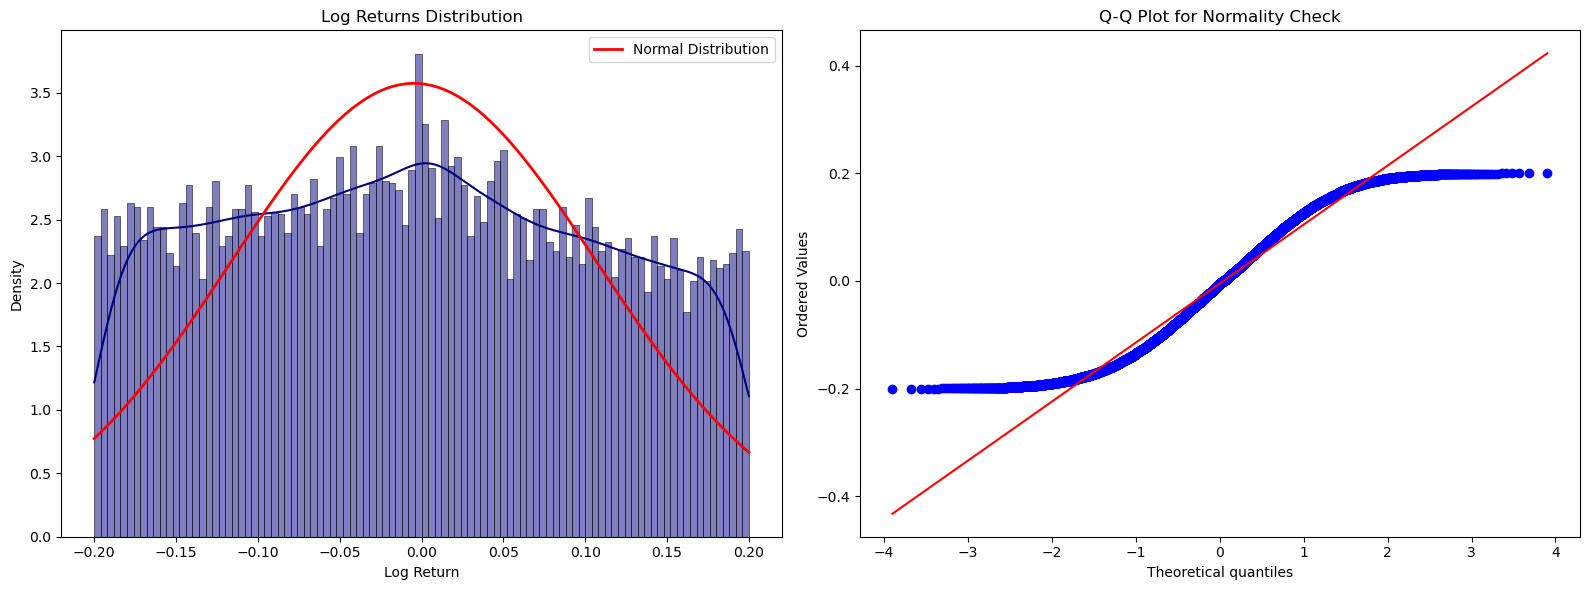

In [11]:
# Plot 3: Log Returns Distribution
# Histogram and Q-Q plot showing the distribution of log returns, with normality check.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram with KDE
filtered_returns = df['log_returns'].dropna()
filtered_returns = filtered_returns[filtered_returns.between(-0.2, 0.2)]
sns.histplot(filtered_returns, bins=100, kde=True, color='navy', stat="density", ax=axes[0])
mu, std = filtered_returns.mean(), filtered_returns.std()
x = np.linspace(-0.2, 0.2, 100)
p = norm.pdf(x, mu, std)
axes[0].plot(x, p, 'r', linewidth=2, label='Normal Distribution')
axes[0].set_title('Log Returns Distribution')
axes[0].set_xlabel('Log Return')
axes[0].set_ylabel('Density')
axes[0].legend()

# Q-Q Plot
stats.probplot(filtered_returns, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot for Normality Check')

plt.tight_layout()
plt.show()


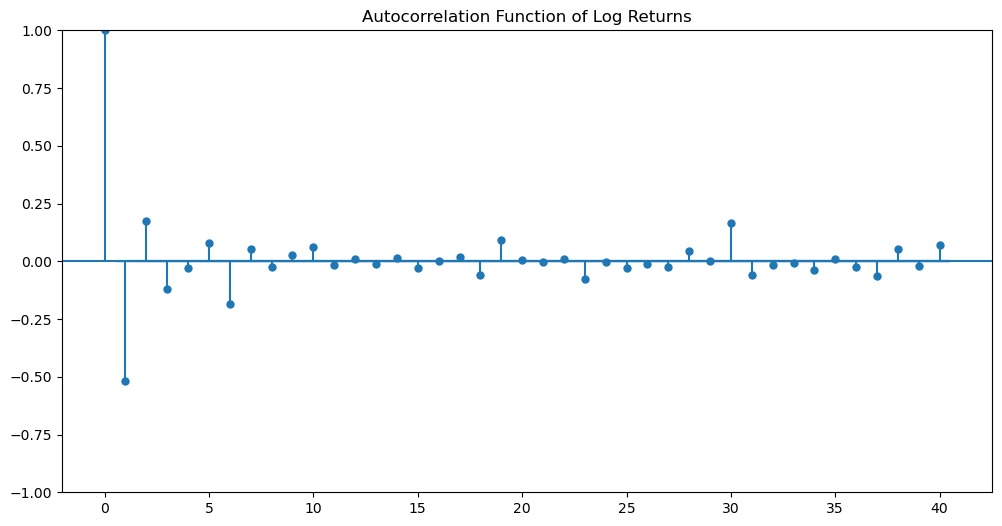

In [12]:
# Plot 4: Autocorrelation Function of Log Returns
# This plot shows the autocorrelation of log returns up to 40 lags to check for momentum or mean reversion.
plt.figure(figsize=(12, 6))
plot_acf(df['log_returns'].dropna(), lags=40, ax=plt.gca())
plt.title('Autocorrelation Function of Log Returns')
plt.show()


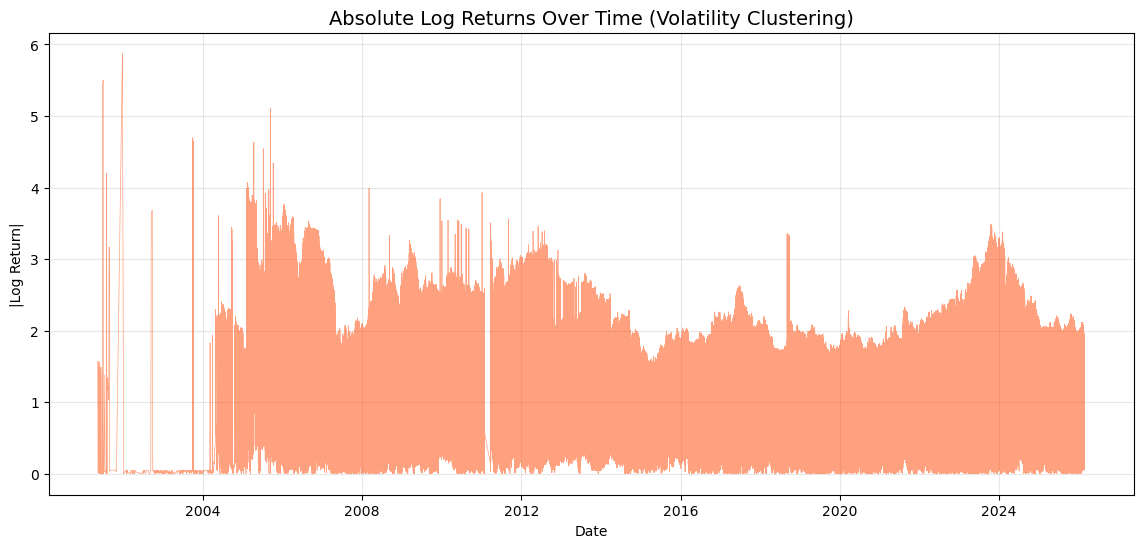

In [13]:
# Plot 5: Volatility Clustering
# Time series of absolute log returns to visualize volatility clustering.
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['abs_returns'], color='orangered', alpha=0.5, linewidth=0.5)
plt.title('Absolute Log Returns Over Time (Volatility Clustering)', fontsize=14)
plt.ylabel('|Log Return|')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.show()


/media/mrawan-shawkey/dev/Apps/conda/envs/istocker/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


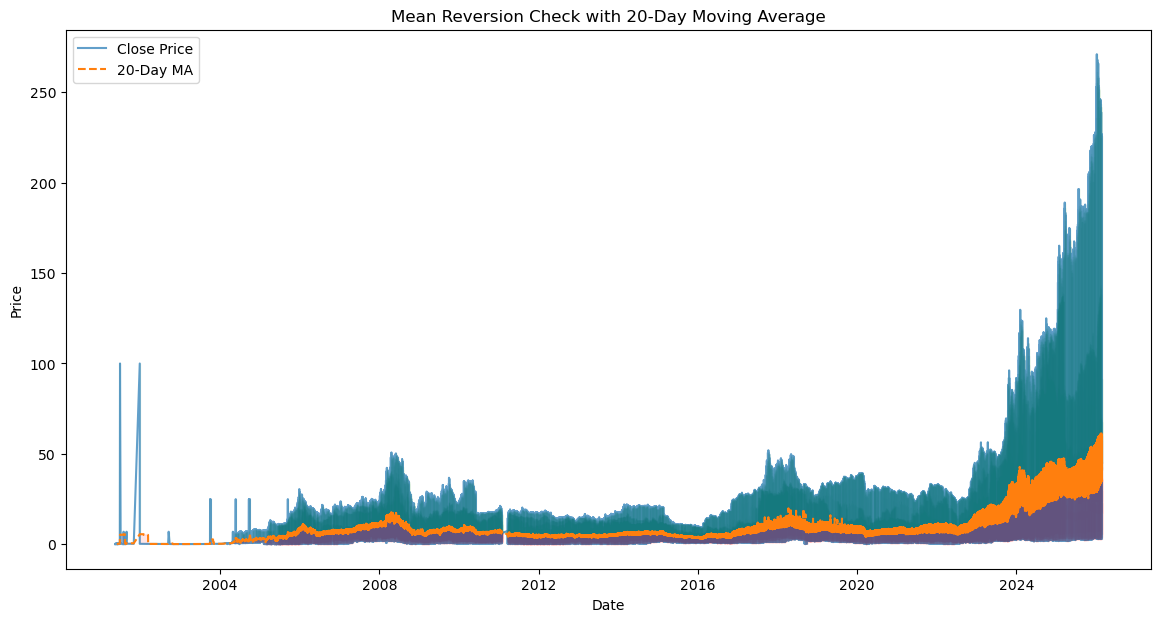

In [14]:
# Plot 6: Mean Reversion Check with Moving Average
# Plot of close price vs 20-day moving average, with colored areas showing deviations.
df['ma20'] = df['close'].rolling(window=20).mean()
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['close'], label='Close Price', alpha=0.7)
plt.plot(df['date'], df['ma20'], label='20-Day MA', linestyle='--')
plt.fill_between(df['date'], df['close'], df['ma20'], where=(df['close'] > df['ma20']), color='green', alpha=0.1)
plt.fill_between(df['date'], df['close'], df['ma20'], where=(df['close'] < df['ma20']), color='red', alpha=0.1)
plt.title('Mean Reversion Check with 20-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


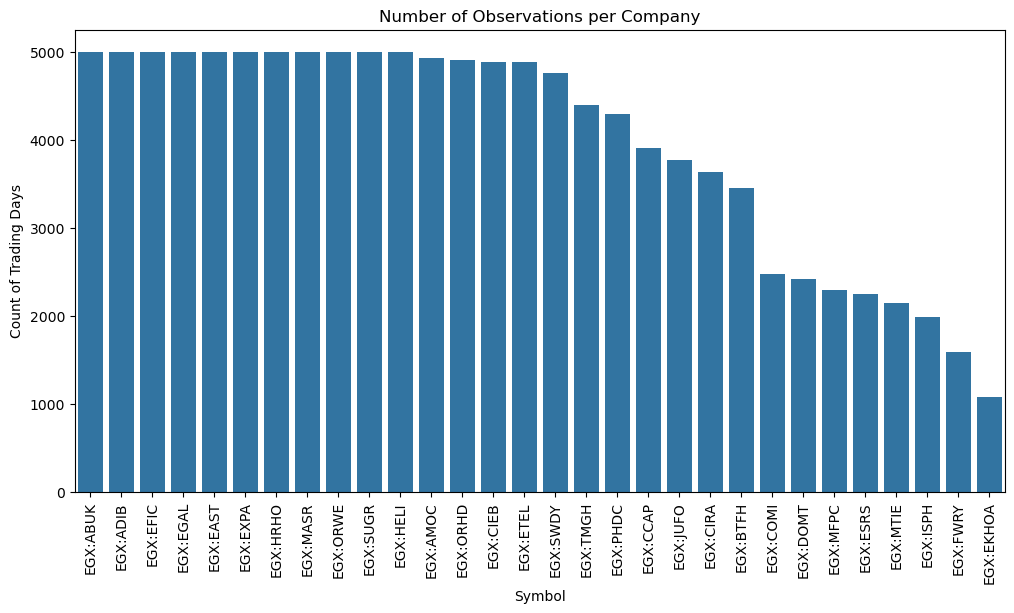

In [15]:
# Plot 7: Observations per Company
# Bar chart showing the number of trading days per company symbol.
counts = df.groupby('symbol').size().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=counts.index, y=counts.values)
plt.xticks(rotation=90)
plt.title("Number of Observations per Company")
plt.ylabel("Count of Trading Days")
plt.xlabel("Symbol")
plt.show()


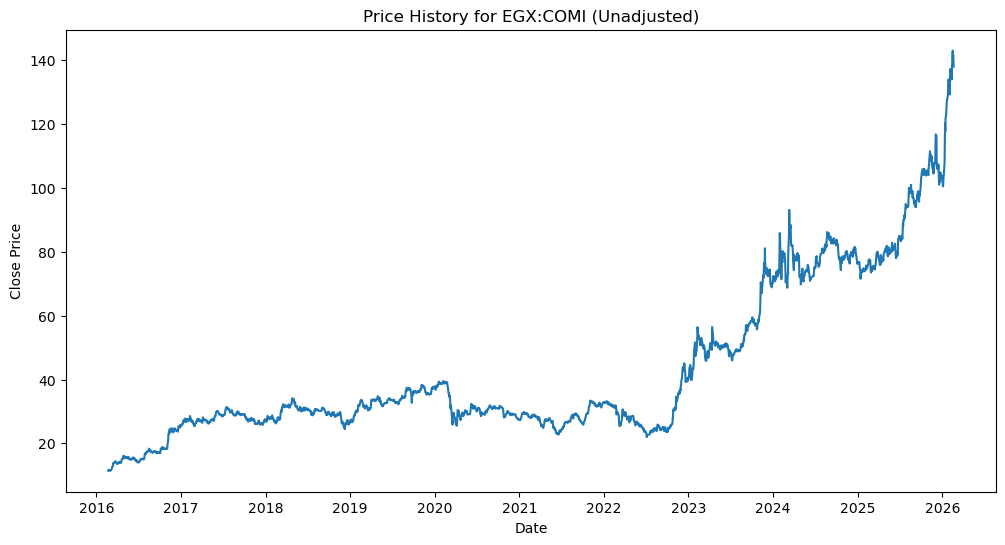

In [16]:
# Plot 8: Price History for Sample Stock (EGX:COMI)
# Time series plot of close price for a sample stock to check for adjustments or splits.
sample_stock = "EGX:COMI"
stock_df = df[df['symbol'] == sample_stock]
plt.figure(figsize=(12, 6))
plt.plot(stock_df['date'], stock_df['close'])
plt.title(f"Price History for {sample_stock} (Unadjusted)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


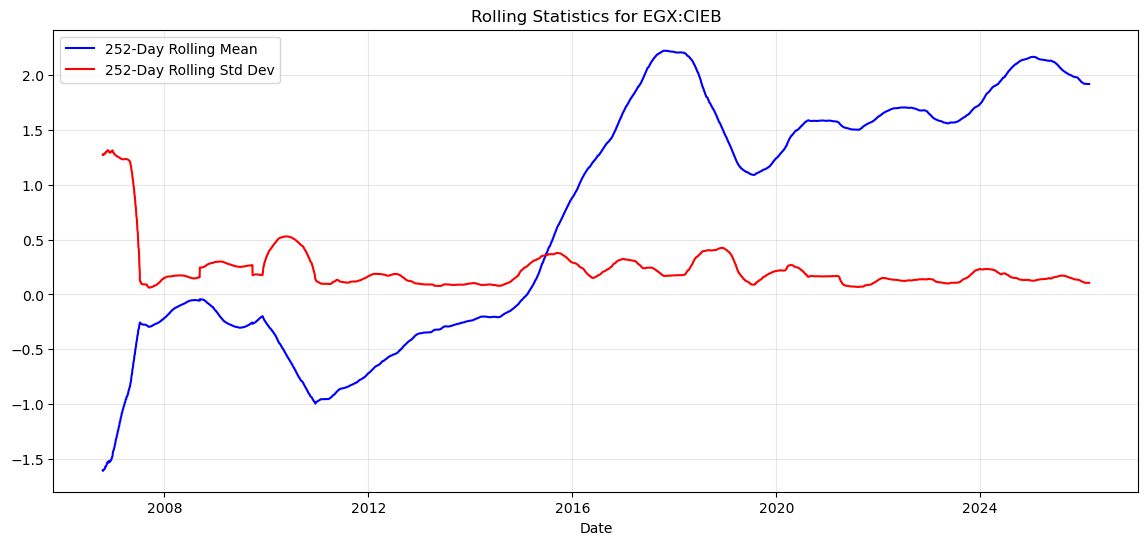

In [17]:
# Plot 9: Rolling Volatility for Sample Stock
# Rolling mean and standard deviation of log returns for a sample stock.
sample_sym = df['symbol'].unique()[0]
sample_df = df[df['symbol'] == sample_sym]
plt.figure(figsize=(14, 6))
plt.plot(sample_df['date'], sample_df['log_returns'].rolling(252).mean(), label='252-Day Rolling Mean', color='blue')
plt.plot(sample_df['date'], sample_df['log_returns'].rolling(252).std(), label='252-Day Rolling Std Dev', color='red')
plt.title(f'Rolling Statistics for {sample_sym}')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


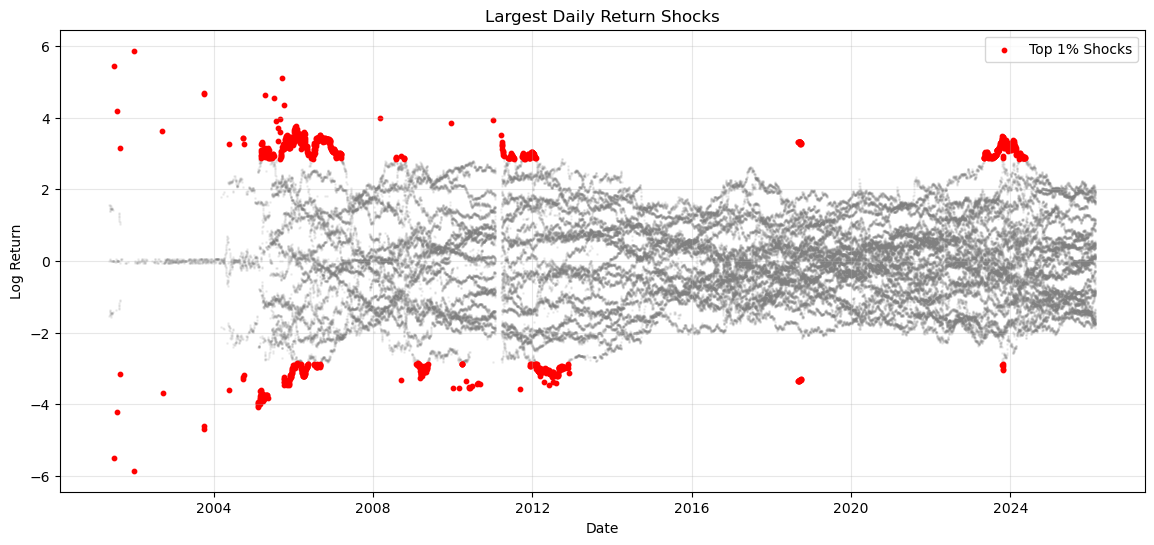

In [18]:
# Plot 10: Largest Return Shocks
# Scatter plot highlighting the top 1% largest absolute returns.
threshold = df['abs_returns'].quantile(0.99)
shocks = df[df['abs_returns'] > threshold]
plt.figure(figsize=(14, 6))
plt.scatter(df['date'], df['log_returns'], color='gray', alpha=0.1, s=1)
plt.scatter(shocks['date'], shocks['log_returns'], color='red', s=10, label='Top 1% Shocks')
plt.title('Largest Daily Return Shocks')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


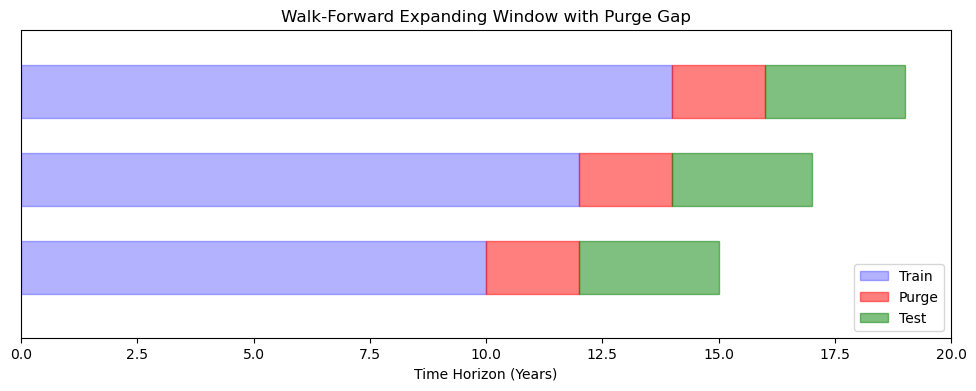

In [19]:
# Plot 11: Walk-Forward Validation Illustration
# Schematic diagram showing train, purge, and test periods for time series validation.
fig, ax = plt.subplots(figsize=(12, 4))
for i in range(3):
    ax.add_patch(patches.Rectangle((0, i), 10 + i*2, 0.6, color='blue', alpha=0.3, label='Train' if i==0 else ""))
    ax.add_patch(patches.Rectangle((10 + i*2, i), 2, 0.6, color='red', alpha=0.5, label='Purge' if i==0 else ""))
    ax.add_patch(patches.Rectangle((12 + i*2, i), 3, 0.6, color='green', alpha=0.5, label='Test' if i==0 else ""))
ax.set_xlim(0, 20)
ax.set_ylim(-0.5, 3)
ax.set_title('Walk-Forward Expanding Window with Purge Gap')
ax.set_xlabel('Time Horizon (Years)')
ax.set_yticks([])
ax.legend()
plt.show()
